In [39]:
import pandas as pd

polymarket_data = pd.read_csv("c:/Users/salomo/Projects/polymarket_sentiment/data/russia_ukraine_ceasfire_2025_polymarket.csv")

polymarket_data.head


<bound method NDFrame.head of             Date (UTC)  Timestamp (UTC)  Price
0     06-30-2025 22:00       1751320807  0.250
1     06-30-2025 23:00       1751324407  0.235
2     07-01-2025 00:00       1751328008  0.235
3     07-01-2025 01:00       1751331607  0.250
4     07-01-2025 02:00       1751335207  0.245
...                ...              ...    ...
1194  08-19-2025 15:00       1755615611  0.385
1195  08-19-2025 16:00       1755619205  0.365
1196  08-19-2025 17:00       1755622813  0.365
1197  08-19-2025 18:00       1755626409  0.365
1198  08-19-2025 18:38       1755628682  0.365

[1199 rows x 3 columns]>

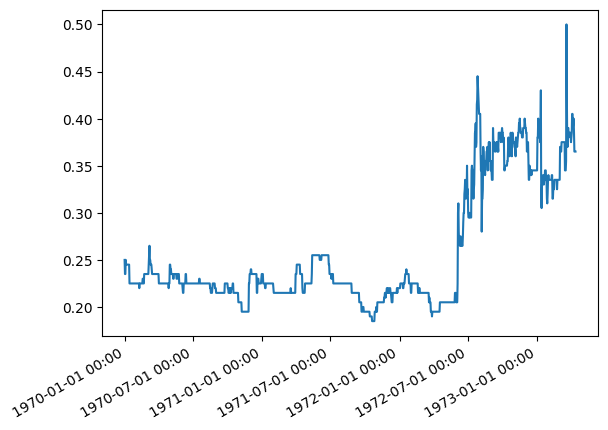

In [40]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots()
ax.plot(polymarket_data["Date (UTC)"], polymarket_data["Price"])
ax.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=10))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
fig.autofmt_xdate()

In [41]:
import dotenv
dotenv.load_dotenv()

True

In [ ]:
# print the smallest timestamp for which we have news in integer UTC Unix timestamp in seconds
news_data = pd.read_csv('data/ukraine_ceasefire_news.csv')
min_time = pd.to_datetime(news_data['hour_start']).min()
print(int(min_time.timestamp()))

1754952138


In [54]:
import pandas as pd
from datetime import datetime, timedelta, timezone
import os, time, requests

API_KEY = os.environ["GNEWS_API_KEY"]
BASE = "https://gnews.io/api/v4/search"
QUERY = "Ukraine Russia ceasefire"
MAX_ARTICLES_PER_REQUEST = 10
MAX_REQUESTS = 100

START_UNIX_TS = 1755297738

results = []
hour_delta = timedelta(hours=1)
requests_made = 0


def dt_utc_from_unix(ts: int) -> datetime:
    return datetime.fromtimestamp(ts, tz=timezone.utc)


if START_UNIX_TS is not None:
    now_dt = dt_utc_from_unix(int(START_UNIX_TS))
else:
    now_dt = datetime.now(timezone.utc)


while requests_made < MAX_REQUESTS:
    end_time = now_dt - requests_made * hour_delta
    start_time = end_time - hour_delta
    
    from_param = start_time.strftime('%Y-%m-%dT%H:%M:%SZ')
    to_param = end_time.strftime('%Y-%m-%dT%H:%M:%SZ')
    params = {
        'q': QUERY,
        'from': from_param,
        'to': to_param,
        'max': MAX_ARTICLES_PER_REQUEST,
        'token': API_KEY,
        'sortby': 'relevance',
        'lang': 'en',
    }
    try:
        r = requests.get(BASE, params=params, timeout=20)
    except requests.RequestException as e:
        print(f"Request failed: {e}")
        break

    if r.status_code != 200:
        print(f"API error or rate limit reached: {r.status_code}")
        break
    data = r.json()
    articles = data.get('articles', [])
    for article in articles:
        article['hour_start'] = from_param
        article['hour_end'] = to_param
        results.append(article)
    requests_made += 1
    time.sleep(1)  # Be kind to the API

df = pd.DataFrame(results)

#append to csv
write_header = not os.path.exists('data/ukraine_ceasefire_news.csv')

if not df.empty:
    df.to_csv('data/ukraine_ceasefire_news.csv', index=False, header=write_header, mode='a')

API error or rate limit reached: 403


In [1]:
from typing import Literal
from openai import OpenAI
import pandas as pd
import time
import json

POS = "positive"
NEG = "negative"

PROMPT_TEMPLATE = """You are an expert analyst of political betting markets. Your task is to classify the influence of a news article on a specific prediction market. You will be given the market description, the article title, description, content, and source URL. Based on this information, you must decide whether the article is likely to have a NEGATIVE, NEUTRAL, or POSITIVE influence on the probability of the event in the market.

Definitions:
- POSITIVE: The article increases the likelihood of the event described in the market becoming true.
- NEGATIVE: The article decreases the likelihood of the event described in the market becoming true.
- NEUTRAL: The article has no clear directional influence on the likelihood of the event.

Instructions:
1. Consider only the article’s relevance to the market. Ignore general sentiment, bias, or unrelated topics.
2. Use the market wording literally. For example, if the market is "Russia x Ukraine ceasefire in 2025?", then any information that makes a ceasefire more likely counts as POSITIVE, and anything that makes it less likely counts as NEGATIVE.
3. Do not output explanations, probabilities, or text beyond the label. Output exactly one word: "positive", "negative", or "neutral".
4. If the article is clearly irrelevant to the market, classify it as "neutral".
5. Ensure the output is lowercase and contains no extra spaces or punctuation.

Input:
[market] = {market}
[title] = {title}
[description] = {description}
[content] = {content}

Output:
"""

def build_prompt(market: str, title: str, description: str, content: str) -> str:
    # Truncate overly long content to control token cost, keep head+tail
    max_chars = 8000
    if len(content) > max_chars:
        head = content[:4000]
        tail = content[-3800:]
        content = f"{head}\n[...truncated...]\n{tail}"
    return PROMPT_TEMPLATE.format(
        market=market.strip(),
        title=title.strip(),
        description=description.strip(),
        content=content.strip()
    )

def map_label(text: str) -> float:
    x = (text or "").strip().lower()
    # Keep first token only, drop punctuation
    x = "".join(ch for ch in x.split()[0] if ch.isalpha())
    if x == POS:
        return 1.0
    elif x == NEG:
        return 0.0
    return 0.5

def classify_article(
    market: str, title: str, description: str, content: str,
    model: str = "gpt-4o-mini", temperature: float = 1, max_retries: int = 2
) -> float:
    client = OpenAI()
    prompt = build_prompt(market, title, description, content)

    for _ in range(max_retries + 1):
        try:
            resp = client.chat.completions.create(
                model=model,
                temperature=temperature,
                messages=[{"role": "user", "content": prompt}],
            )
            out = resp.choices[0].message.content
            return map_label(out)
        except Exception as e:
            print(f"Error classifying article: {e}")
            time.sleep(21)

    return 0.5

def classify_articles_parallel(
    market: str, articles: list, 
    model: str = "gpt-4o-mini", temperature: float = 0
) -> list:
    from concurrent.futures import ThreadPoolExecutor, as_completed

    def classify_single(article):
        return classify_article(
            market, article['title'], article.get('description', ''),
            article['content'], model=model, temperature=temperature
        )

    results = []
    with ThreadPoolExecutor(max_workers=5) as executor:
        futures = {executor.submit(classify_single, article): article for article in articles}
        for future in as_completed(futures):
            try:
                result = future.result()
                results.append(result)
            except Exception as e:
                print(f"Error processing article: {e}")
                results.append(0.5)  # Default to neutral on error

    return results


market = "Russia x Ukraine ceasefire in 2025?"

df = pd.read_csv("data/ukraine_ceasefire_news.csv")
# Read existing rated articles to avoid duplicates
try:
    rated_df = pd.read_csv("data/ukraine_ceasefire_news_rated.csv")
    rated_ids = set(rated_df['id'].tolist())
except FileNotFoundError:
    rated_df = pd.DataFrame()
    rated_ids = set()

# Filter articles that haven't been rated yet
unrated_articles = df[~df['id'].isin(rated_ids)]

if len(unrated_articles) > 0:
    print(f"Found {len(unrated_articles)} unrated articles to classify...")
    
    # Convert to list of dictionaries for batch processing
    articles_to_classify = unrated_articles.to_dict('records')
    
    # Use batch classification
    sentiment_scores = classify_articles_parallel(market, articles_to_classify)
    
    # Add sentiment scores to the unrated articles
    unrated_articles = unrated_articles.copy()
    unrated_articles['sentiment'] = sentiment_scores
    
    # Combine with existing rated articles
    if len(rated_df) > 0:
        updated_df = pd.concat([rated_df, unrated_articles], ignore_index=True)
    else:
        updated_df = unrated_articles
    
    # Save updated results
    updated_df.to_csv("data/ukraine_ceasefire_news_rated.csv", index=False)
    print(f"Added sentiment scores for {len(unrated_articles)} articles")
else:
    print("All articles have already been rated")

Found 252 unrated articles to classify...
Added sentiment scores for 252 articles


In [4]:
import pandas as pd

news_data = pd.read_csv("data/ukraine_ceasefire_news_rated.csv")
# convert publishedAt to utc timestamp
news_data["timestamp"] = pd.to_datetime(news_data["publishedAt"], utc=True).astype(int) // 10**9
prices = pd.read_csv("data/russia_ukraine_ceasfire_2025_polymarket.csv")
# new dataframe with columns timestamp, delta_price and sentiment, each column comes from different df
df = pd.DataFrame({
    "timestamp": prices["Timestamp (UTC)"].astype(int),
    "delta_time": prices["Timestamp (UTC)"].diff().fillna(0).astype(int),
    "price": prices["Price"],
    "delta_price": prices["Price"].diff().fillna(0),
})

min_time = int(pd.to_datetime(news_data['hour_start']).min().timestamp())
df = df[df["timestamp"] > min_time]

# calculate average over all sentiments falling in the timestamp+delta_time
df["sentiment"] = df[["timestamp", "delta_time"]].apply(
    lambda row: news_data["sentiment"][
        (news_data["timestamp"] >= row["timestamp"])
        & (news_data["timestamp"] < row["timestamp"] + row["delta_time"])
    ].mean(),
    axis=1
)

# if there was no news, assume there was no impact
df["sentiment"] = df["sentiment"].fillna(0.5)

df.to_csv("data/russia_ukraine_ceasfire_2025_polymarket_with_sentiment.csv", index=False)

In [5]:
# calculate how sentiment and price change correlate
corr = {}
for off in range(-24, 25):
    corr[off] = df["delta_price"].shift(off).corr(df["sentiment"])

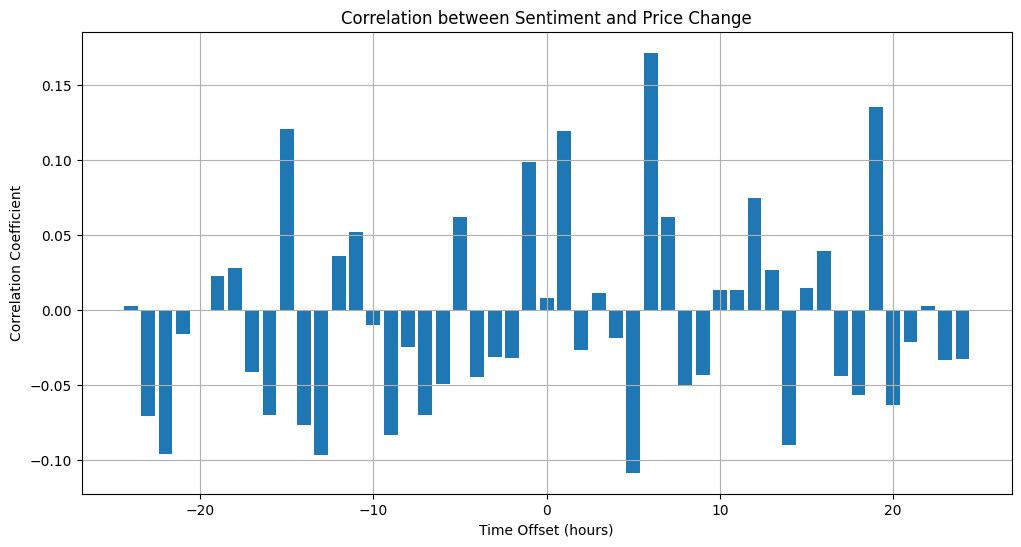

In [7]:
# plot cor in barplot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(corr.keys(), corr.values())
plt.title("Correlation between Sentiment and Price Change")
plt.xlabel("Time Offset (hours)")
plt.ylabel("Correlation Coefficient")
plt.grid()
plt.show()